In [1]:
import requests
from bs4 import BeautifulSoup
import time, collections, re
import pandas as pd #dataframe for storing final data
import matplotlib.pyplot as plt #plotting histogram of data


In [6]:
# Scraping raw data from the website

url = 'https://collegedunia.com/exams/cat/cutoff'
source_code = requests.get(url)
plain_txt = source_code.text
soup_obj = BeautifulSoup(plain_txt, 'lxml')

Cutoff_data = pd.DataFrame(columns=['Section', 'Cutoff', 'Institute', 'Date'])

In [7]:
# Scraping the needed institutes from the page and converting to required format 

ins_names = [s.get_text().replace('\xa0',' ') for s in soup_obj.find_all('h3', {'class':''})][6:20]
ins_names = [' '.join(s.split(' ')[:2]) for s in ins_names]

# Retrieving the needed tables from the page

tables = [s for s in soup_obj.find_all('table')][5:19]

In [10]:
 # Retrieving the needed information from all the above tables 
    
for t in range(len(tables)):
    headers = ['Section', 'Cutoff'] +[s.get_text() for s in tables[t].find_all('th')][2:]
    row_data = [s.get_text() for s in tables[t].find_all('td')]

    h_len, r_len =len(headers), len(row_data)
    
    table = collections.OrderedDict()

    for i in range(r_len):
        table.setdefault(headers[i%h_len],[]).append(row_data[i])

    table_data = collections.OrderedDict({k: table[k] for k in list(table)[:2]})
    df = pd.DataFrame(data=table_data)

    # to add date of scraping and institute name 
    date = []
    institute = []
    current_date = time.strftime("%d/%m/%Y")

    for i in range(r_len//h_len):
        date.append(current_date)
        institute.append(ins_names[t])

    df = df.assign(Institute=institute)
    df=df.assign(Date=date)
    
    # Resetting null entries to 0
    df.Cutoff = df.Cutoff.replace(u'-', u'0')

    # Writing clean data to dataFrame 
    for i in range(len(df)):
        if df.iloc[i,0] == 'Overall Percentile':
            Cutoff_data = Cutoff_data.append(df.iloc[i,:], ignore_index=True)
           

In [11]:
# Exporting data-frame to a csv and .txt file

with open('Cutoff_data.txt', 'w') as f:
    Cutoff_data.to_string(f)

Cutoff_data.to_csv('IIM_cutoffs_data_2017-18.csv')

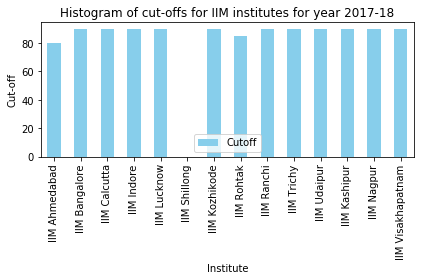

In [12]:
# Plotting histogram from dataFrame

Cutoff_data['Cutoff'] = (Cutoff_data['Cutoff']).astype(int)
plot = Cutoff_data.plot(x='Institute', y='Cutoff', kind='bar', color='skyblue')
fig=plot.get_figure()

# Labeling the histogram
plt.xlabel("Institute")
plt.ylabel("Cut-off")
plt.title("Histogram of cut-offs for IIM institutes for year 2017-18")

plt.tight_layout()

# saving the resultant histogram as an image
fig.savefig('Cutoff_Histogram_visualization.png')

plt.show()